In [1]:
import time
import torch
import json
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

from models_package.models import Teacher, Student

In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 5 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
patience = 7  # for early stopping
lmda = 0.01 #3
batch_size = 256
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# class StratifiedBatchSampler:
#     """Stratified batch sampling
#     Provides equal representation of target classes in each batch
#     """
#     def __init__(self, y, batch_size, shuffle=True):
#         if torch.is_tensor(y):
#             y = y.numpy()
#         assert len(y.shape) == 1, 'label array must be 1D'
#         n_batches = int(len(y) / batch_size)
#         self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
#         self.X = torch.randn(len(y),1).numpy()
#         self.y = y
#         self.shuffle = shuffle
#         self.batch_size = batch_size

#     def __iter__(self):
#         if self.shuffle:
#             self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
#         for train_idx, test_idx in self.skf.split(self.X, self.y):
#             yield test_idx

#     def __len__(self):
#         return len(self.y)//self.batch_size

In [5]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):
        # Define the original class labels

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data['images']

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            

        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            return remapped_label
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [6]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [7]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        # Option 1: Return a placeholder tensor (adapt the shape to match your data)
        # return torch.tensor([]), torch.tensor([])
        # Option 2: Raise an exception
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [8]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
# test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


# trainloader = DataLoader(train_dataset, 
#                          batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), batch_size=batch_size),
#                          num_workers=num_workers, collate_fn=custom_collate)
# testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)




In [9]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


trainloader = DataLoader(train_dataset, 
                          batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [10]:
from collections import Counter

# Iterate through batches in the trainloader
for batch_idx, batch in enumerate(trainloader):
    # Only process the first 3 batches
    if batch_idx >= 3:
        break

    # Extract labels for the current batch
    batch_labels = batch['label']

    # Convert batch_labels to a list if it's not already (e.g., if it's a tensor)
    if not isinstance(batch_labels, list):
        batch_labels = batch_labels.tolist()

    # Count the frequency of each label in this batch
    label_counts = Counter(batch_labels)

    # Print the label counts for this batch
    print(f"Batch {batch_idx + 1} class counts:")
    for label in range(30):  # Assuming classes are labeled from 0 to 29
        print(f"  Class {label}: {label_counts[label]} instances")
    print("-" * 30)  # Just a separator for clarity


Batch 1 class counts:
  Class 0: 18 instances
  Class 1: 7 instances
  Class 2: 10 instances
  Class 3: 6 instances
  Class 4: 6 instances
  Class 5: 7 instances
  Class 6: 2 instances
  Class 7: 2 instances
  Class 8: 5 instances
  Class 9: 10 instances
  Class 10: 3 instances
  Class 11: 10 instances
  Class 12: 4 instances
  Class 13: 13 instances
  Class 14: 4 instances
  Class 15: 9 instances
  Class 16: 5 instances
  Class 17: 7 instances
  Class 18: 3 instances
  Class 19: 15 instances
  Class 20: 7 instances
  Class 21: 15 instances
  Class 22: 15 instances
  Class 23: 6 instances
  Class 24: 9 instances
  Class 25: 11 instances
  Class 26: 16 instances
  Class 27: 11 instances
  Class 28: 10 instances
  Class 29: 10 instances
------------------------------
Batch 2 class counts:
  Class 0: 24 instances
  Class 1: 7 instances
  Class 2: 6 instances
  Class 3: 12 instances
  Class 4: 7 instances
  Class 5: 4 instances
  Class 6: 3 instances
  Class 7: 2 instances
  Class 8: 7 ins

In [11]:
print(len(train_dataset))
print(len(test_dataset))

10324
3453


In [12]:
train_dataset[0]

{'label': 0,
 'target': tensor([0.6250]),
 'img': tensor([[[-0.7137, -0.7308, -0.7308,  ...,  2.0948,  2.0605,  1.7009],
          [-0.6965, -0.7650, -0.7308,  ...,  2.0777,  2.0263,  1.5982],
          [-0.6794, -0.7822, -0.7479,  ...,  2.0777,  1.9920,  1.5297],
          ...,
          [-1.3302, -1.1932, -1.2617,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7308, -0.7650, -0.7993,  ..., -2.1179, -2.1179, -2.1179],
          [-0.5082, -0.6965, -0.8164,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-0.5826, -0.6001, -0.6001,  ...,  2.0609,  2.0259,  1.6583],
          [-0.5651, -0.6352, -0.6001,  ...,  2.0434,  2.0259,  1.6057],
          [-0.5476, -0.6527, -0.6176,  ...,  2.0259,  1.9909,  1.5707],
          ...,
          [-1.1604, -1.0028, -1.0728,  ..., -2.0357, -2.0357, -2.0357],
          [-0.4776, -0.4951, -0.5126,  ..., -2.0357, -2.0357, -2.0357],
          [-0.1625, -0.3725, -0.5301,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-0.4450, -0.4624, -0.4624,  ...,  1.9951

In [13]:
# all_train_labels = []

# # Iterate through the DataLoader to collect all labels
# for batch in trainloader:
#     labels = batch['label'].numpy()  # Convert to NumPy array if not already
#     all_train_labels.extend(labels)

# # Convert the list to a NumPy array
# all_train_labels = np.array(all_train_labels)

# # Find the unique classes and their frequencies
# unique_classes, class_frequencies = np.unique(all_train_labels, return_counts=True)
# normalized_class_weights = torch.from_numpy(class_frequencies).float().to(device)

In [14]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_label_frequencies(train_labels, class_names):
#     # Count the occurrences of each label in the training set
#     train_label_counts = np.bincount(train_labels)

#     # Count the occurrences of each label in the test set

#     # Create a bar plot
#     fig, ax = plt.subplots(figsize=(10, 6))
#     bar_width = 0.35
#     index = np.arange(len(class_names))

#     # Plot training set frequencies
#     train_bars = ax.bar(index, train_label_counts, bar_width, label='Train Set')

#     # Plot test set frequencies

#     # Add labels, title, and legend
#     ax.set_xlabel('Class')
#     ax.set_ylabel('Frequency')
#     ax.set_title('Label Frequencies in Train Sets')
#     ax.set_xticks(index + bar_width / 2)
#     ax.set_xticklabels(class_names)
#     ax.legend()

#     # Show the plot
#     plt.show()

# # Extract labels from the data
# # train_labels = [train_dataset[i]['label'] for i in range(len(train_dataset))]
# # test_labels = [test_dataset[i]['label'] for i in range(len(test_dataset))]

# # List of class names
# class_names = [f'Class {i+1}' for i in range(1, len(set(all_train_labels)) + 1)]

# # Plot label frequencies
# plot_label_frequencies(all_train_labels, class_names)


# Start Training Process

In [15]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()



In [16]:
def true_positive_parity(actual_labels, y_pred, gender_labels, num_classes):
    # Ensure actual_labels is an array of integers representing class labels
    actual_labels = np.array(actual_labels, dtype=int)

    # Convert gender_labels to binary (0 for female, 1 for male)
    binary_gender_labels = (gender_labels >= 0.5).astype(int)

    # Initialize arrays to store true positive rates for each gender and class
    female_true_positive_rates = np.zeros(num_classes)
    male_true_positive_rates = np.zeros(num_classes)

    for class_label in range(num_classes):
        # Identify indices corresponding to female and male for the current class
        female_indices = np.logical_and(binary_gender_labels == 0, actual_labels == class_label)
        male_indices = np.logical_and(binary_gender_labels == 1, actual_labels == class_label)

        # Calculate true positive rates for the current class
        female_true_positive_rates[class_label] = (
            np.sum((y_pred[female_indices] == class_label) & (actual_labels[female_indices] == class_label)) /
            np.sum(actual_labels == class_label)
        )

        male_true_positive_rates[class_label] = (
            np.sum((y_pred[male_indices] == class_label) & (actual_labels[male_indices] == class_label)) /
            np.sum(actual_labels == class_label)
        )

    # Calculate the absolute difference in true positive rates between male and female for each class
    true_positive_parity_per_class = np.abs(female_true_positive_rates - male_true_positive_rates)

    # Average over all classes to get an overall measure
    true_positive_parity_average = np.mean(true_positive_parity_per_class)

    return true_positive_parity_average



In [17]:
class RecallDifferenceCalculator:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.cumulative_true_positives = np.zeros((self.num_classes, 2))  # Two columns for male and female
        self.cumulative_actual_positives = np.zeros((self.num_classes, 2))

    def update(self, actual_labels, y_pred, gender_labels):
        actual_labels = np.array(actual_labels.cpu(), dtype=int)
        y_pred = np.array(y_pred.cpu(), dtype=int)
        gender_labels = np.array(gender_labels.cpu())  # Gender labels are continuous

        # Classify gender based on threshold
        female_indices = gender_labels <= 0.5
        male_indices = gender_labels > 0.5

        for class_label in range(self.num_classes):
            # Update counts for female
            indices_female = np.logical_and(female_indices, actual_labels == class_label)
            true_positives_female = np.logical_and(indices_female, y_pred == class_label)
            self.cumulative_true_positives[class_label, 0] += np.sum(true_positives_female)
            self.cumulative_actual_positives[class_label, 0] += np.sum(indices_female)

            # Update counts for male
            indices_male = np.logical_and(male_indices, actual_labels == class_label)
            true_positives_male = np.logical_and(indices_male, y_pred == class_label)
            self.cumulative_true_positives[class_label, 1] += np.sum(true_positives_male)
            self.cumulative_actual_positives[class_label, 1] += np.sum(indices_male)

            print(f"Class {class_label}, Female TP: {np.sum(true_positives_female)}, Male TP: {np.sum(true_positives_male)}")


    def compute_recall_difference(self):
        recalls = np.divide(
            self.cumulative_true_positives,
            self.cumulative_actual_positives,
            out=np.zeros_like(self.cumulative_true_positives, dtype=float),
            where=self.cumulative_actual_positives != 0
        )

        # Calculate the difference in recall between the demographic groups for each class
        recall_differences = recalls[:, 1] - recalls[:, 0]  # Assuming 1 is male and 0 is female

        # Pair each class label with its recall difference
        recall_diff_by_class = {label: diff for label, diff in enumerate(recall_differences)}

        return recall_diff_by_class


In [18]:
# class RecallDifferenceCalculator:
#     def __init__(self, num_classes):
#         self.num_classes = num_classes
#         self.reset()

#     def reset(self):
#         self.cumulative_true_positives = np.zeros(self.num_classes)
#         self.cumulative_actual_positives = np.zeros(self.num_classes)
#         self.cumulative_predicted_positives = np.zeros(self.num_classes)

#     def update(self, actual_labels, y_pred, gender_labels):
#         # Ensure actual_labels is an array of integers representing class labels
#         actual_labels = np.array(actual_labels.cpu(), dtype=float)
#         y_pred = np.array(y_pred.cpu(), dtype=int)
#         # Convert gender_labels to binary (0 for female, 1 for male)
#         gender_labels = np.array(gender_labels.cpu(), dtype=float)
#         binary_gender_labels = (gender_labels >= 0.5).astype(int)

#         for class_label in range(self.num_classes):
#             # Identify indices corresponding to female and male for the current class
#             female_indices = np.logical_and(binary_gender_labels == 0, actual_labels == class_label)
#             male_indices = np.logical_and(binary_gender_labels == 1, actual_labels == class_label)

#             # Update cumulative statistics
#             self.cumulative_true_positives[class_label] += (
#                 np.sum(np.where(np.logical_and(female_indices, actual_labels == class_label),
#                                 y_pred, 0) == class_label) +
#                 np.sum(np.where(np.logical_and(male_indices, actual_labels == class_label),
#                                 y_pred, 0) == class_label)
#             )


#             self.cumulative_actual_positives[class_label] += np.sum(actual_labels == class_label)
#             self.cumulative_predicted_positives[class_label] += np.sum(y_pred == class_label)

#     def compute_recall_difference(self):
#         # Calculate recall for each class
#         class_recall = np.divide(self.cumulative_true_positives, self.cumulative_actual_positives, 
#                                  where=self.cumulative_actual_positives != 0, out=np.zeros_like(self.cumulative_true_positives))
    
#         # Calculate the difference in recall between male and female for each class
#         recall_difference_per_class = class_recall[1] - class_recall[0]
    
#         # Compute the average recall difference across all classes
#         # average_recall_difference = np.mean(recall_difference_per_class)
    
#         return recall_difference_per_class


# recalc = RecallDifferenceCalculator(30)

In [19]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
teacher_model.fc = nn.Linear(512,30)
student_model = torchvision.models.resnet18(weights=None).to(device)
student_model.fc = nn.Linear(512,30)


# # Load teacher
# teacher_model = torch.load('teacher_model_ckd_prof.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_prof_checkpoint.pth'))
# teacher_model = teacher_model.to(device)
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)




In [20]:
class Adversary(nn.Module):
    def __init__(self, identity_labels=1):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(512, 64)
        self.a2 = nn.Linear(64, identity_labels)
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.xavier_normal_(self.a2.weight)

    def forward(self, input_ids):
        input_ids = input_ids.view(input_ids.size(0), -1)
        adversary = F.relu(self.a1(input_ids))
        adversary_output = self.a2(adversary)
        return adversary_output

adv = Adversary()
adv = adv.to(device)

In [21]:
modules=list(student_model.children())[:-1]
student_features=nn.Sequential(*modules)


In [22]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()
# print("Adversarial Criterion:", adv_criterion)


In [23]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

    return student

In [24]:
def pretrain_adversary(adv, student, optimizer, trainloader, adv_criterion, epochs):
  
  pretrain_adversary_loss = 0
  steps = 0

  for epoch in range(epochs):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        optimizer.zero_grad()
        classifier_prev_output = student_features(inputs)
        adversary_output = adv(classifier_prev_output)
        # print("Adversary output sample:", adversary_output[0])
        adversary_loss = adv_criterion(adversary_output, targets)
        adversary_loss.backward() # back prop
        optimizer.step()
        pretrain_adversary_loss += adversary_loss.item()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1
        steps += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

  return adv

In [25]:
# pretrain_student(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=3, patience=5)
# pretrain_adversary(adv, student_model, optimizer, trainloader, adv_criterion, epochs=1)


In [26]:
# #### finding the optimal learning rate
# def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(num_epochs):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best learning rate: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
# print(best_lr)

In [27]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [28]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, epochs, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}| Validation Accuracy: {accuracy * 100:.2f}%')
            
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")


def train_adversary(adv, student, optimizer, trainloader, adv_criterion, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)): 
            inputs = data['img'].to(device)
            targets = data['target'].to(device)  # Ensure targets are in the range [0, 1] for BCEWithLogitsLoss

            optimizer.zero_grad()

            # Assuming student_features is a function or part of the student model
            # that extracts the necessary features for the adversary
            classifier_prev_output = student_features(inputs)
            adversary_output = adv(classifier_prev_output)

            adversary_loss = adv_criterion(adversary_output, targets)
            adversary_loss.backward()
            optimizer.step()

            epoch_loss += adversary_loss.item()
            epoch_batches += 1

        print(f"Average Adversary epoch loss: {epoch_loss/epoch_batches}")
    return adv



# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, optimizer, scheduler, device, alpha, temperature, epochs, lmda, patience=5):
    teacher.eval()
    teacher.to(device)
    
    # Create an instance of RecallDifferenceCalculator
    num_classes = len(class_labels)
    recalc = RecallDifferenceCalculator(num_classes)

    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)            
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
                
            classifier_prev_output = student_features(inputs)
            # print("Feature shape:", classifier_prev_output.shape)
            # print("Sample features:", classifier_prev_output[0, :5])
            # print("Input features to adversary, sample:", classifier_prev_output[0])

            
            adversary_output = adv(classifier_prev_output)
            adversary_loss = criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            

            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss - lmda * adversary_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            # epoch_disparity += disparity

        
        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                with torch.no_grad():
                    val_teacher_outputs = teacher(val_inputs)


                val_classifier_prev_output = student_features(val_inputs)
                val_adversary_output = adv(val_classifier_prev_output)
                val_adversary_loss = criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()

                
                val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss - lmda * val_adversary_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recalc.update(val_labels, predicted, val_targets)

            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            recall_difference_epoch = recalc.compute_recall_difference()
            print(f"Epoch {epoch + 1}: Difference in Recall by Class: {recall_difference_epoch}")
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}| Validation Accuracy: {accuracy * 100:.2f}%')

        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()

    print("Finished Training Student")
    plot_loss_curve(val_losses)

In [29]:
# train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)
train_adversary(adv, student_model, optimizer, trainloader, adv_criterion, num_epochs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:49<00:00,  2.67s/it]


Average Adversary epoch loss: 0.2317224054074869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:49<00:00,  2.68s/it]


Average Adversary epoch loss: 0.17711873643281983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:49<00:00,  2.67s/it]


Average Adversary epoch loss: 0.16976945974477908


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:48<00:00,  2.65s/it]


Average Adversary epoch loss: 0.16781057635458504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:48<00:00,  2.66s/it]

Average Adversary epoch loss: 0.166346533269417


Adversary(
  (a1): Linear(in_features=512, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=1, bias=True)
)

  7%|███████▊                                                                                                      | 1/14 [00:05<01:09,  5.33s/it]

Class 0, Female TP: 33534, Male TP: 28674
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0

 14%|███████████████▋                                                                                              | 2/14 [00:06<00:32,  2.74s/it]

Class 0, Female TP: 1785, Male TP: 2055
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 21%|███████████████████████▌                                                                                      | 3/14 [00:07<00:20,  1.89s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 29%|███████████████████████████████▍                                                                              | 4/14 [00:08<00:15,  1.52s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 36%|███████████████████████████████████████▎                                                                      | 5/14 [00:10<00:15,  1.70s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 43%|███████████████████████████████████████████████▏                                                              | 6/14 [00:11<00:12,  1.57s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 552, Male TP: 472
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 50%|███████████████████████████████████████████████████████                                                       | 7/14 [00:12<00:09,  1.35s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 891, Male TP: 1925
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, M

 57%|██████████████████████████████████████████████████████████████▊                                               | 8/14 [00:13<00:07,  1.20s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 56, Male TP: 200
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 56, Male TP: 200
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 64%|██████████████████████████████████████████████████████████████████████▋                                       | 9/14 [00:15<00:07,  1.42s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 161, Male TP: 95
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 483, Male TP: 285
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0,

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 10/14 [00:16<00:05,  1.32s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 11/14 [00:17<00:03,  1.24s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 12/14 [00:18<00:02,  1.12s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13/14 [00:18<00:01,  1.04s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.39s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T


  7%|███████▊                                                                                                      | 1/14 [00:05<01:08,  5.26s/it]

Class 0, Female TP: 35328, Male TP: 30208
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0

 14%|███████████████▋                                                                                              | 2/14 [00:06<00:32,  2.69s/it]

Class 0, Female TP: 1785, Male TP: 2055
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 21%|███████████████████████▌                                                                                      | 3/14 [00:07<00:20,  1.87s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 29%|███████████████████████████████▍                                                                              | 4/14 [00:07<00:14,  1.50s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 36%|███████████████████████████████████████▎                                                                      | 5/14 [00:10<00:16,  1.80s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 43%|███████████████████████████████████████████████▏                                                              | 6/14 [00:11<00:11,  1.49s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 50%|███████████████████████████████████████████████████████                                                       | 7/14 [00:12<00:09,  1.29s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 57%|██████████████████████████████████████████████████████████████▊                                               | 8/14 [00:12<00:06,  1.16s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 56, Male TP: 200
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Mal

 64%|██████████████████████████████████████████████████████████████████████▋                                       | 9/14 [00:15<00:07,  1.53s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 10/14 [00:16<00:05,  1.33s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 11/14 [00:17<00:04,  1.36s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 12/14 [00:18<00:02,  1.20s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13/14 [00:19<00:01,  1.09s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.41s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T


  7%|███████▊                                                                                                      | 1/14 [00:05<01:08,  5.23s/it]

Class 0, Female TP: 35328, Male TP: 30208
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0

 14%|███████████████▋                                                                                              | 2/14 [00:06<00:32,  2.67s/it]

Class 0, Female TP: 1785, Male TP: 2055
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 21%|███████████████████████▌                                                                                      | 3/14 [00:06<00:20,  1.85s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 29%|███████████████████████████████▍                                                                              | 4/14 [00:07<00:14,  1.46s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 36%|███████████████████████████████████████▎                                                                      | 5/14 [00:10<00:17,  1.90s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 43%|███████████████████████████████████████████████▏                                                              | 6/14 [00:11<00:12,  1.58s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 138, Male TP: 118
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 50%|███████████████████████████████████████████████████████                                                       | 7/14 [00:12<00:09,  1.36s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 162, Male TP: 350
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 57%|██████████████████████████████████████████████████████████████▊                                               | 8/14 [00:13<00:07,  1.22s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 56, Male TP: 200
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Mal

 64%|██████████████████████████████████████████████████████████████████████▋                                       | 9/14 [00:15<00:07,  1.56s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 10/14 [00:16<00:05,  1.35s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 11/14 [00:17<00:03,  1.24s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 12/14 [00:18<00:02,  1.12s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13/14 [00:19<00:01,  1.03s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.40s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T


  7%|███████▊                                                                                                      | 1/14 [00:05<01:08,  5.23s/it]

Class 0, Female TP: 35190, Male TP: 30090
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0

 14%|███████████████▋                                                                                              | 2/14 [00:06<00:31,  2.67s/it]

Class 0, Female TP: 1785, Male TP: 2055
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 21%|███████████████████████▌                                                                                      | 3/14 [00:06<00:20,  1.86s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 29%|███████████████████████████████▍                                                                              | 4/14 [00:07<00:15,  1.50s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 36%|███████████████████████████████████████▎                                                                      | 5/14 [00:10<00:16,  1.85s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 43%|███████████████████████████████████████████████▏                                                              | 6/14 [00:11<00:12,  1.54s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 414, Male TP: 354
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 50%|███████████████████████████████████████████████████████                                                       | 7/14 [00:12<00:09,  1.33s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 405, Male TP: 875
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 57%|██████████████████████████████████████████████████████████████▊                                               | 8/14 [00:13<00:07,  1.18s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 56, Male TP: 200
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 56, Male TP: 200
Class 22, Female TP: 56, Male TP: 200
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 

 64%|██████████████████████████████████████████████████████████████████████▋                                       | 9/14 [00:15<00:07,  1.58s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 322, Male TP: 190
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 10/14 [00:16<00:05,  1.36s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 11/14 [00:17<00:03,  1.20s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 12/14 [00:18<00:02,  1.09s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13/14 [00:19<00:01,  1.09s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.41s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T


  7%|███████▊                                                                                                      | 1/14 [00:05<01:08,  5.25s/it]

Class 0, Female TP: 35190, Male TP: 30090
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0

 14%|███████████████▋                                                                                              | 2/14 [00:06<00:32,  2.69s/it]

Class 0, Female TP: 1666, Male TP: 1918
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 21%|███████████████████████▌                                                                                      | 3/14 [00:07<00:20,  1.87s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 29%|███████████████████████████████▍                                                                              | 4/14 [00:07<00:14,  1.47s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 36%|███████████████████████████████████████▎                                                                      | 5/14 [00:10<00:16,  1.85s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 43%|███████████████████████████████████████████████▏                                                              | 6/14 [00:11<00:12,  1.54s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 552, Male TP: 472
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 50%|███████████████████████████████████████████████████████                                                       | 7/14 [00:12<00:09,  1.34s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 1134, Male TP: 2450
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, 

 57%|██████████████████████████████████████████████████████████████▊                                               | 8/14 [00:13<00:07,  1.19s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 56, Male TP: 200
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 56, Male TP: 200
Class 22, Female TP: 56, Male TP: 200
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 

 64%|██████████████████████████████████████████████████████████████████████▋                                       | 9/14 [00:15<00:08,  1.68s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 966, Male TP: 570
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Ma

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 10/14 [00:16<00:05,  1.43s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 11/14 [00:17<00:03,  1.26s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 12/14 [00:18<00:02,  1.13s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13/14 [00:19<00:01,  1.04s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.42s/it]

Class 0, Female TP: 0, Male TP: 0
Class 1, Female TP: 0, Male TP: 0
Class 2, Female TP: 0, Male TP: 0
Class 3, Female TP: 0, Male TP: 0
Class 4, Female TP: 0, Male TP: 0
Class 5, Female TP: 0, Male TP: 0
Class 6, Female TP: 0, Male TP: 0
Class 7, Female TP: 0, Male TP: 0
Class 8, Female TP: 0, Male TP: 0
Class 9, Female TP: 0, Male TP: 0
Class 10, Female TP: 0, Male TP: 0
Class 11, Female TP: 0, Male TP: 0
Class 12, Female TP: 0, Male TP: 0
Class 13, Female TP: 0, Male TP: 0
Class 14, Female TP: 0, Male TP: 0
Class 15, Female TP: 0, Male TP: 0
Class 16, Female TP: 0, Male TP: 0
Class 17, Female TP: 0, Male TP: 0
Class 18, Female TP: 0, Male TP: 0
Class 19, Female TP: 0, Male TP: 0
Class 20, Female TP: 0, Male TP: 0
Class 21, Female TP: 0, Male TP: 0
Class 22, Female TP: 0, Male TP: 0
Class 23, Female TP: 0, Male TP: 0
Class 24, Female TP: 0, Male TP: 0
Class 25, Female TP: 0, Male TP: 0
Class 26, Female TP: 0, Male TP: 0
Class 27, Female TP: 0, Male TP: 0
Class 28, Female TP: 0, Male T

Finished Training Student


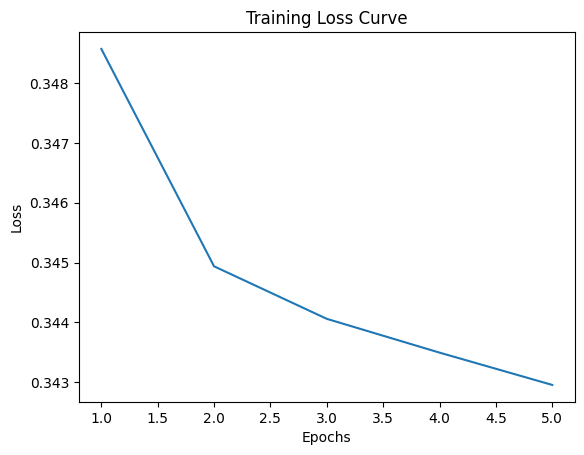

In [30]:
train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, lmda=0.25, patience=5)


In [31]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_prof.pth')
torch.save(student_model, 'student_model_ckd_prof.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_prof.pth')
torch.save(teacher_model, 'teacher_model_ckd_prof.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


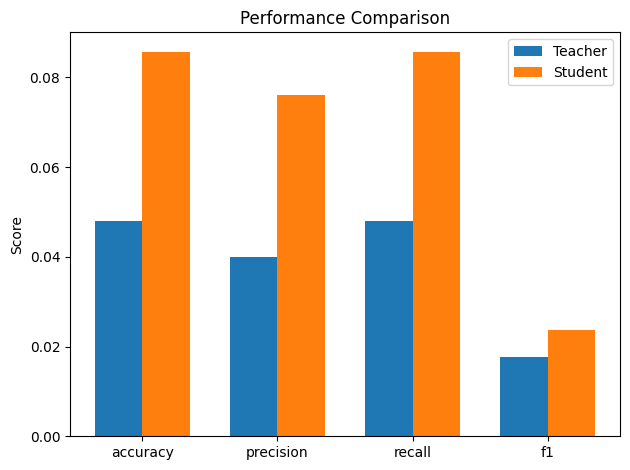

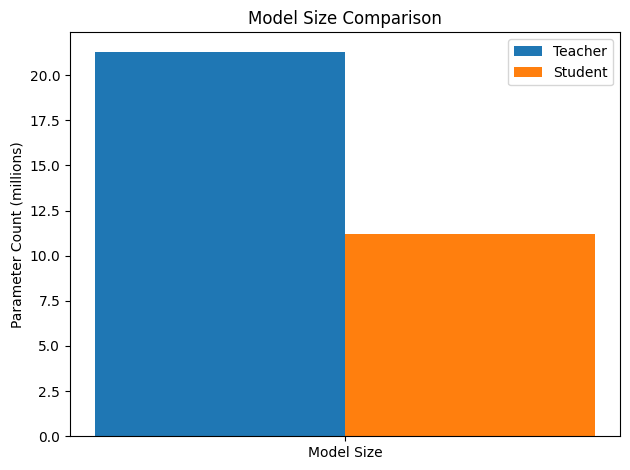

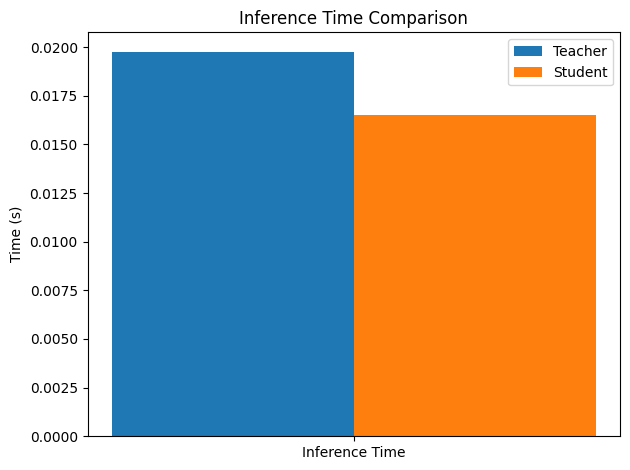

In [32]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics['metrics'][metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics['metrics'][metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [33]:
def calculate_recall(preds, targets, condition):
    """
    Calculate recall for a given condition in a multi-class setting.

    :param preds: Predicted classes.
    :param targets: True classes.
    :param condition: Boolean tensor indicating the condition (subset) for which to calculate recall.
    :return: Recall value.
    """
    if condition.sum() == 0:  # No samples meet the condition
        return 0.0

    filtered_preds = preds[condition]
    filtered_targets = targets[condition]

    true_positive = (filtered_preds == filtered_targets).sum().float()
    condition_positive = filtered_targets.size(0)

    recall = true_positive / condition_positive if condition_positive > 0 else 0.0
    return recall
    
def calculate_weighted_disparity(disparity_sums, counts):
    """
    Calculate weighted disparity for each class-attribute pair.
    """
    weighted_disparities = torch.zeros_like(disparity_sums)
    for class_idx in range(disparity_sums.size(0)):
        for attr_idx in range(disparity_sums.size(1)):
            if counts[class_idx][attr_idx] > 0:
                weighted_disparities[class_idx][attr_idx] = disparity_sums[class_idx][attr_idx] / counts[class_idx][attr_idx]
            else:
                weighted_disparities[class_idx][attr_idx] = 0.0
    return weighted_disparities

def evaluate_disparity(model, dataloader, num_classes, device):
    """
    Evaluate the disparity on the test data with weighted consideration.
    """
    model.eval()
    disparity_sums = None
    counts = None

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            targets = batch['label'].to(device)
            attributes = batch['target'].to(device)

            if disparity_sums is None:
                disparity_sums = torch.zeros(num_classes, attributes.size(1), device=device)
                counts = torch.zeros(num_classes, attributes.size(1), device=device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for class_idx in range(num_classes):
                for attr_idx in range(attributes.size(1)):
                    condition_present = (attributes[:, attr_idx] == 1) & (targets == class_idx)
                    condition_absent = (attributes[:, attr_idx] == 0) & (targets == class_idx)

                    if condition_present.sum() > 0 or condition_absent.sum() > 0:
                        recall_present = calculate_recall(preds, targets, condition_present)
                        recall_absent = calculate_recall(preds, targets, condition_absent)

                        disparity = abs(recall_present - recall_absent)
                        count = condition_present.sum() + condition_absent.sum()
                        disparity_sums[class_idx][attr_idx] += disparity * count
                        counts[class_idx][attr_idx] += count

    weighted_disparities = calculate_weighted_disparity(disparity_sums, counts)

    for class_idx in range(num_classes):
        for attr_idx in range(attributes.size(1)):
            print(f"Class: {class_idx}, Attr: {attr_idx}, Weighted Disparity: {weighted_disparities[class_idx][attr_idx]}")

    weighted_average = weighted_disparities.flatten()
    weighted_average = weighted_average.sum()/weighted_average.numel()
    return weighted_average

In [34]:
disparity = evaluate_disparity(student_model, testloader, num_classes=num_classes, device=device)
print(f'Average recall disparity across all attributes and classes: {disparity}')


Class: 0, Attr: 0, Weighted Disparity: 0.01607142761349678
Class: 1, Attr: 0, Weighted Disparity: 0.0
Class: 2, Attr: 0, Weighted Disparity: 0.0
Class: 3, Attr: 0, Weighted Disparity: 0.0
Class: 4, Attr: 0, Weighted Disparity: 0.0
Class: 5, Attr: 0, Weighted Disparity: 0.0
Class: 6, Attr: 0, Weighted Disparity: 0.0
Class: 7, Attr: 0, Weighted Disparity: 0.0
Class: 8, Attr: 0, Weighted Disparity: 0.0
Class: 9, Attr: 0, Weighted Disparity: 0.0
Class: 10, Attr: 0, Weighted Disparity: 0.0
Class: 11, Attr: 0, Weighted Disparity: 0.0
Class: 12, Attr: 0, Weighted Disparity: 0.0
Class: 13, Attr: 0, Weighted Disparity: 0.0
Class: 14, Attr: 0, Weighted Disparity: 0.0
Class: 15, Attr: 0, Weighted Disparity: 0.0
Class: 16, Attr: 0, Weighted Disparity: 0.0
Class: 17, Attr: 0, Weighted Disparity: 0.0
Class: 18, Attr: 0, Weighted Disparity: 0.0
Class: 19, Attr: 0, Weighted Disparity: 0.09245197474956512
Class: 20, Attr: 0, Weighted Disparity: 0.0
Class: 21, Attr: 0, Weighted Disparity: 0.010869565419

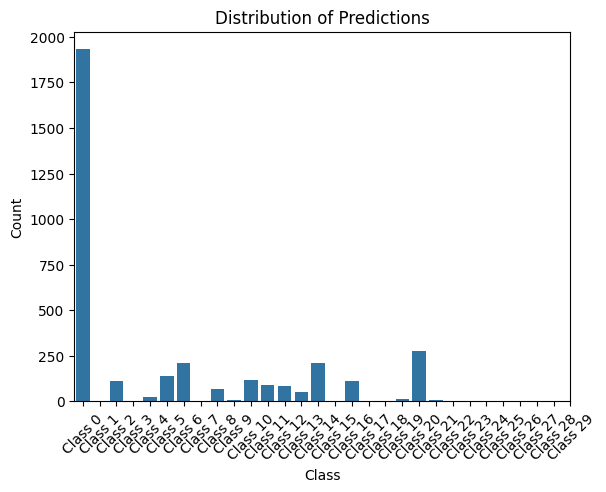

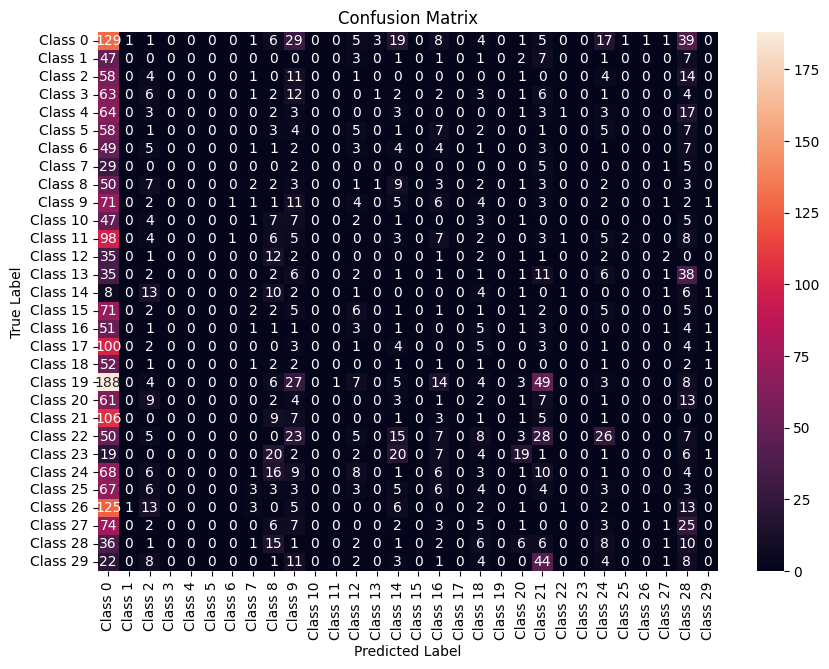

              precision    recall  f1-score   support

     Class 0       0.07      0.48      0.12       271
     Class 1       0.00      0.00      0.00        70
     Class 2       0.04      0.04      0.04        94
     Class 3       0.00      0.00      0.00       104
     Class 4       0.00      0.00      0.00       100
     Class 5       0.00      0.00      0.00        94
     Class 6       0.00      0.00      0.00        81
     Class 7       0.00      0.00      0.00        42
     Class 8       0.01      0.02      0.02        89
     Class 9       0.05      0.10      0.07       115
    Class 10       0.00      0.00      0.00        78
    Class 11       0.00      0.00      0.00       145
    Class 12       0.00      0.00      0.00        59
    Class 13       0.00      0.00      0.00       107
    Class 14       0.00      0.00      0.00        50
    Class 15       0.00      0.00      0.00       104
    Class 16       0.00      0.00      0.00        74
    Class 17       0.00    

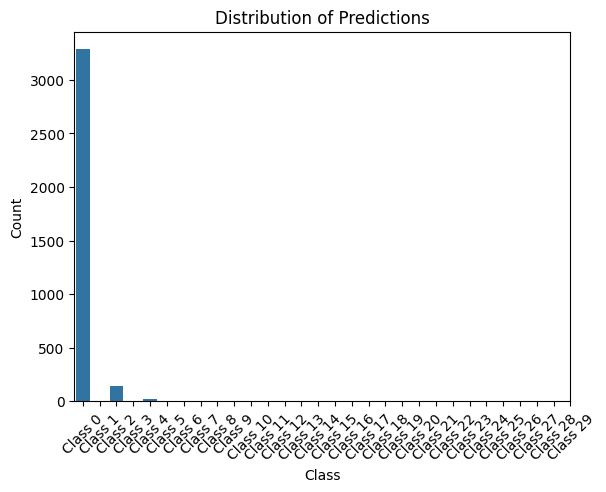

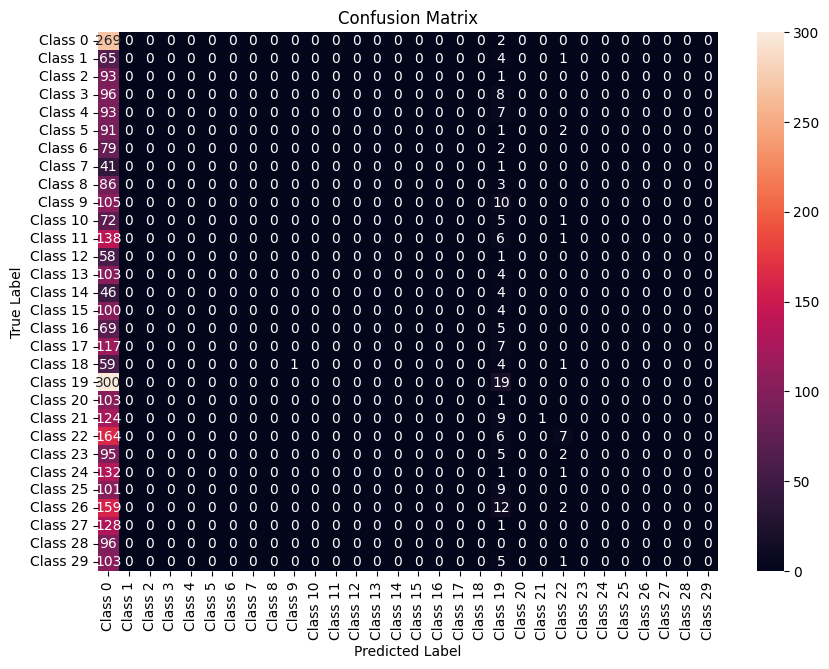

              precision    recall  f1-score   support

     Class 0       0.08      0.99      0.15       271
     Class 1       0.00      0.00      0.00        70
     Class 2       0.00      0.00      0.00        94
     Class 3       0.00      0.00      0.00       104
     Class 4       0.00      0.00      0.00       100
     Class 5       0.00      0.00      0.00        94
     Class 6       0.00      0.00      0.00        81
     Class 7       0.00      0.00      0.00        42
     Class 8       0.00      0.00      0.00        89
     Class 9       0.00      0.00      0.00       115
    Class 10       0.00      0.00      0.00        78
    Class 11       0.00      0.00      0.00       145
    Class 12       0.00      0.00      0.00        59
    Class 13       0.00      0.00      0.00       107
    Class 14       0.00      0.00      0.00        50
    Class 15       0.00      0.00      0.00       104
    Class 16       0.00      0.00      0.00        74
    Class 17       0.00    

In [35]:
class_names_new = [f"Class {label}" for label in range(30)]
def plot_prediction_distribution_and_confusion_matrix(labels, preds, class_names):
    # Plotting the distribution of predictions
    sns.countplot(x=preds)
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.show()

    # Computing the confusion matrix
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names_new, columns=class_names_new)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report for detailed metrics
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))

performance_metrics_teacher = compare_performance_metrics(teacher_model, student_model, testloader)
all_labels = performance_metrics_teacher['all_labels']
all_teacher_preds = performance_metrics_teacher['all_teacher_preds']
all_student_preds = performance_metrics_teacher['all_student_preds']

# For the Teacher Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_teacher_preds, class_names_new)

# For the Student Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_student_preds, class_names_new)

In [36]:
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
modules=list(student_model.children())[:-1]
student_features=nn.Sequential(*modules)

In [38]:
student_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [39]:
for name, param in student_model.named_parameters():
    if "weight" in name:  # assuming the last layer has a weight parameter
        last_layer_hidden_size = param.size(0)  # The first dimension is the hidden size
        break

In [40]:
last_layer_hidden_size

64

In [41]:
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  